## Temporal Block Simulations

In [3]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
from multiprocessing import Pool
from functools import partial
import pandas as pd
import scipy
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

In [13]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.slimfile as sf
from cvtk.gintervals import GenomicIntervals
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.process_sims import extract_runs, load_pickled, load_stats
from cvtk.process_sims import params_vary_over, col_palette, averge_runs
from cvtk.utils import integerize
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [6]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [7]:
max_nreps = 20

In [8]:
DATADIR = "../data/sims_intermediate/block_sampling/"

## Covariance Under Truncation Selection

Here, we're only looking at 1000 sampled individuals (e.g. no bottleneck), and one population.

In [9]:
converters = dict(N=int, alpha=float, nmu=float, rbp=float, tmu=float,
                  region_length=int, sampleN=int, shifttime=int, tail=float)

block_results = load_pickled(DATADIR, converters=converters)

In [10]:
len(block_results)

1

In [14]:
stacked_results = averge_runs(block_results)

/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
k = list(stacked_results.keys())[0]
stacked_results[k][0].shape

(30, 99, 99)

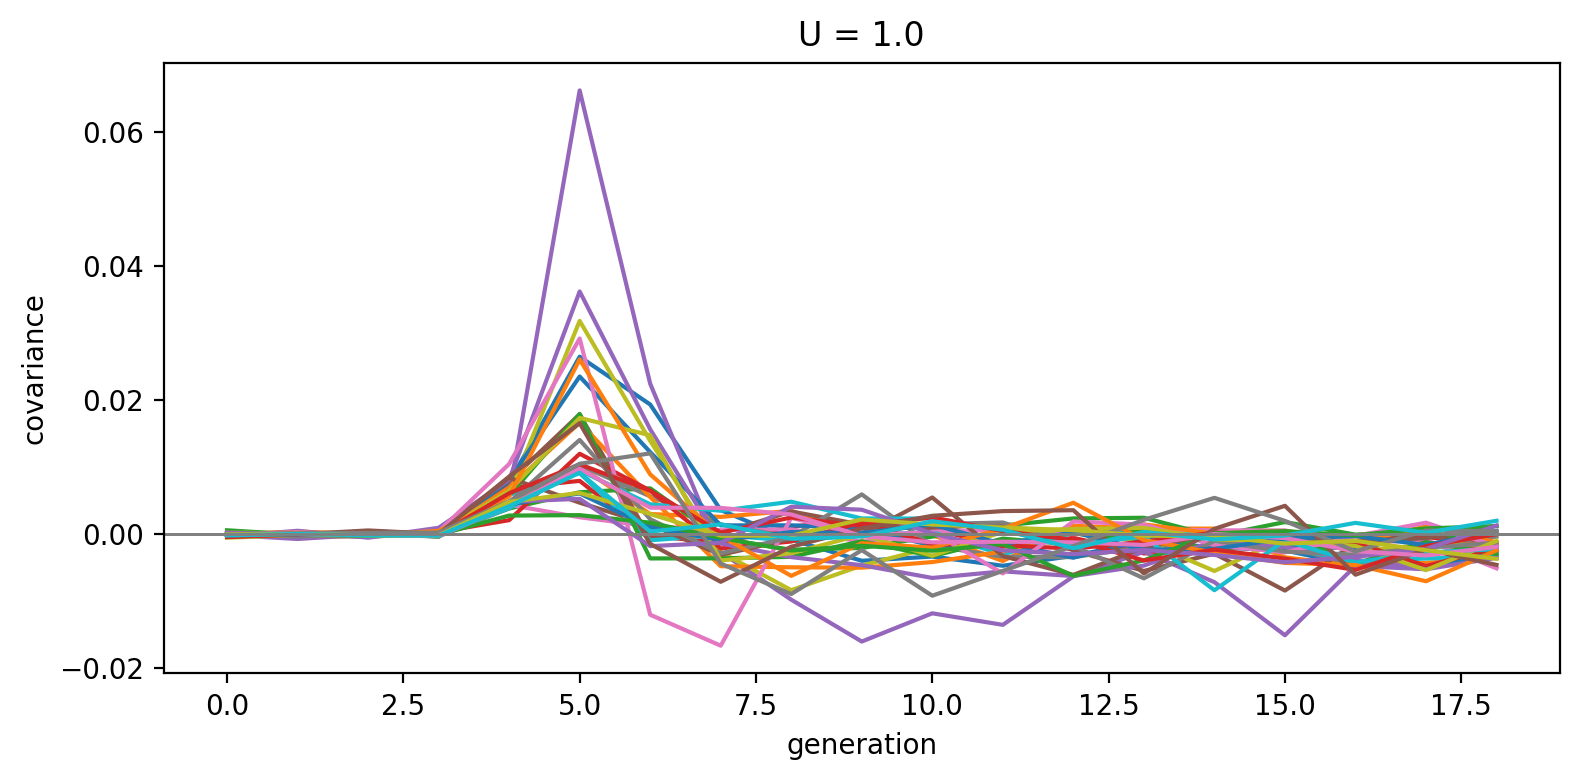

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=1)

maxgen = 20
ref = 5

# crap you need to do because matplotlib...
labset = set()

for params, (covs, Gs) in stacked_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    for i in range(covs.shape[0]):
        cov = covs[i, ...]
        n = cov.shape[0] # assumes these are all the same shape
        idx = (np.arange(n) != ref) & (np.arange(n) < maxgen)
        lab=""
        ax.plot(cov[ref, idx], '-', label=lab, alpha=1)
        ax.set_xlabel("generation")
        ax.set_ylabel("covariance")
        ax.set_title("U = 1.0")
        ax.axhline(0, c='0.5', linewidth=1)


plt.tight_layout()

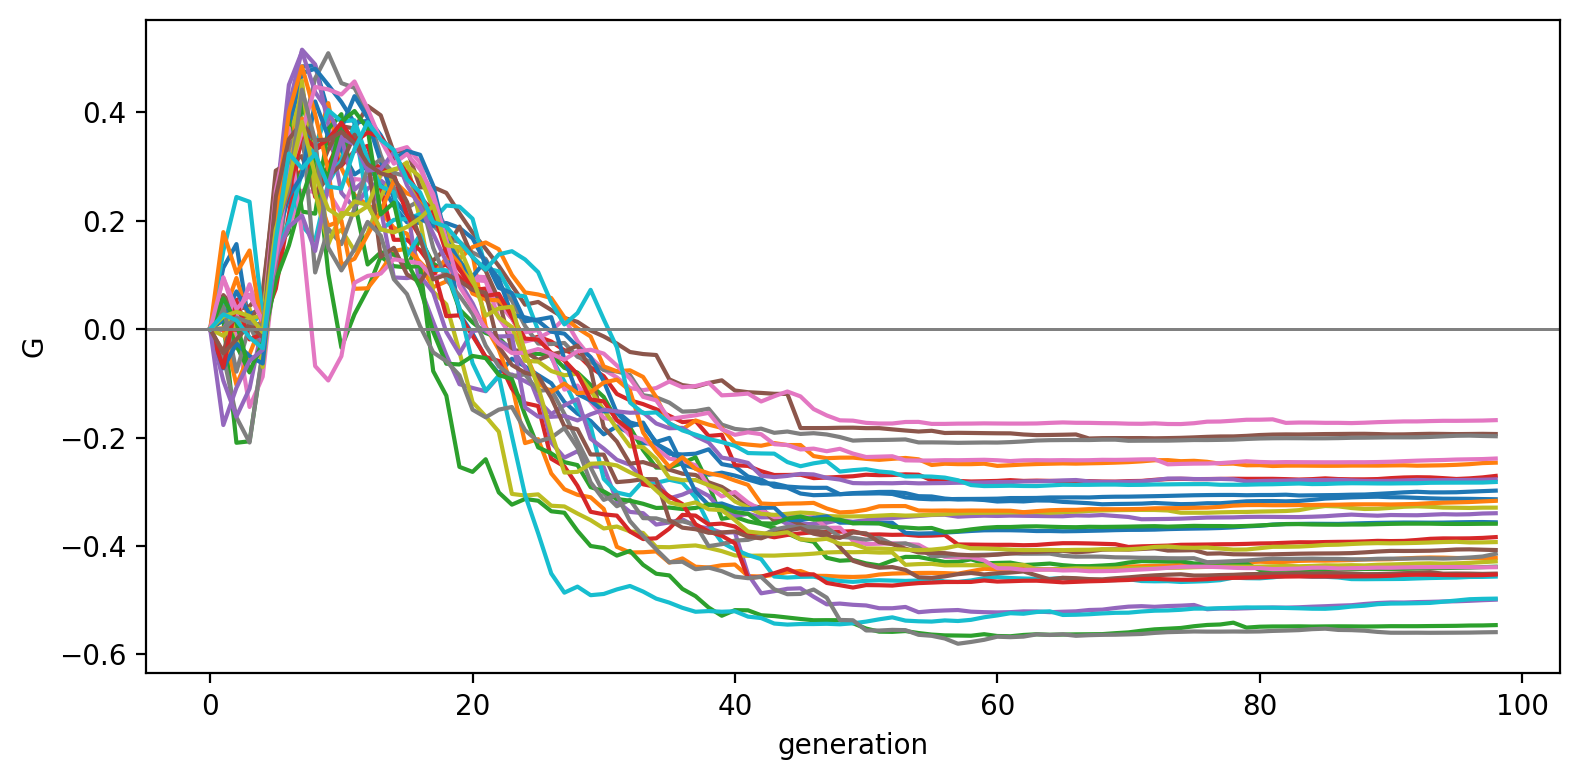

In [39]:
fig, ax = plt.subplots(ncols=1, nrows=1)

maxgen = 20
ref = 5

# crap you need to do because matplotlib...
labset = set()

for params, (covs, Gs) in stacked_results.items():
    params = dict(params)
    
    cov = covs.mean(axis=0)
    for i in range(covs.shape[0]):
        G = Gs[i, ...]
        ax.plot(G, '-', label=lab, alpha=1)
        ax.set_xlabel("generation")
        ax.set_ylabel("G")
        ax.set_title("")
        ax.axhline(0, c='0.5', linewidth=1)


plt.tight_layout()

### Plot Gs

In [ ]:
tail_cols = col_palette(param_covs['tail'], cm.Dark2)

for params, runs in converge_1k_covs.items():
    params = dict(params)
    for r, (covs, Gs, dims) in enumerate(runs):
        lab = f"tail = {params['tail']}" if r == 0 else ""
        plt.plot(Gs[:, 0], c=tail_cols[params['tail']], label=lab)
        plt.plot(Gs[:, 1], c=tail_cols[params['tail']], label="")
        plt.xlimit((0, 10))
plt.legend(frameon=False, ncol=2)
plt.xlabel("generation")
plt.ylabel("G")

## Simulation Statistics

In [25]:
sim_stats = [[sf.parse_slim_stats(f) for f in files] for files in res.results.stats_file.values]

In [31]:
len(res.results.key.to_list())

[autoreload of cvtk.slimfile failed: Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/vsb/miniconda3/envs/cvtk/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/vsb/miniconda3/envs/cvtk/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_remov

576

In [118]:
len(sim_stats)

1

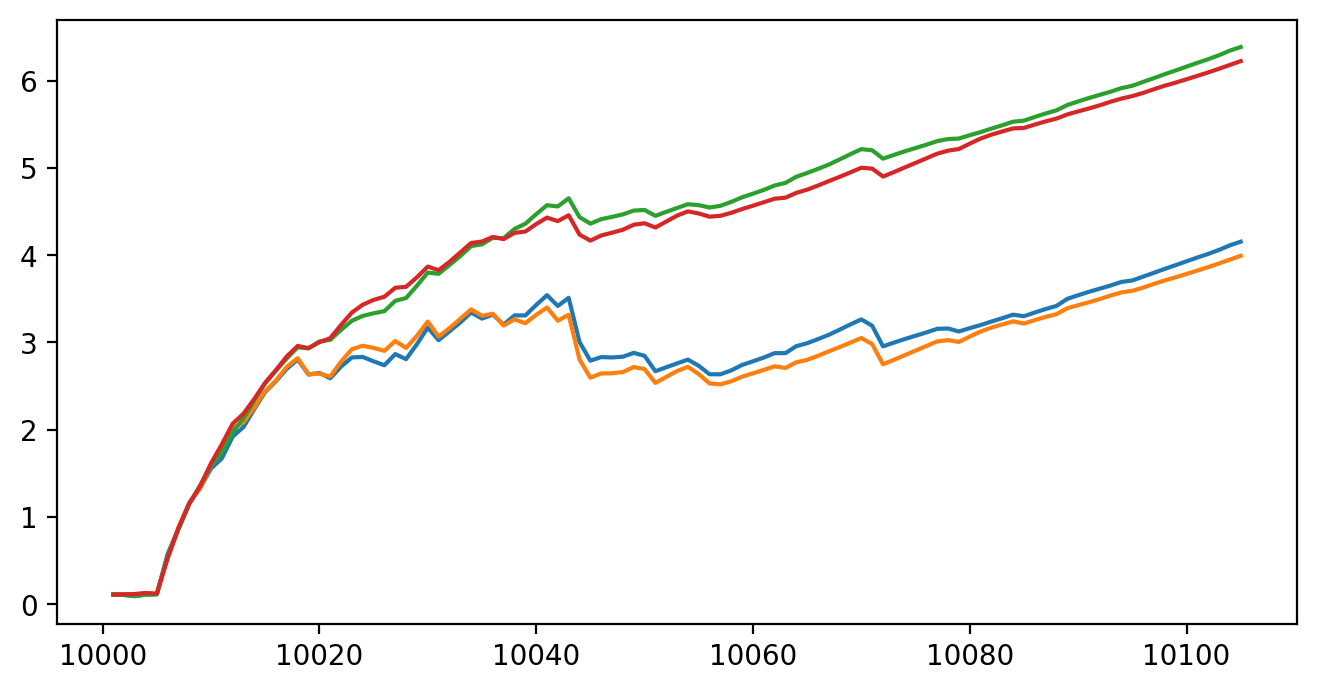

In [119]:
plt.plot(sim_stats[0].stats.generation, sim_stats[0].stats.zbar_nofix_1)
plt.plot(sim_stats[0].stats.generation, sim_stats[0].stats.zbar_nofix_2)
plt.plot(sim_stats[0].stats.generation, sim_stats[0].stats.zbar_1)
plt.plot(sim_stats[0].stats.generation, sim_stats[0].stats.zbar_2)
#plt.axvline(10010, c='gray')

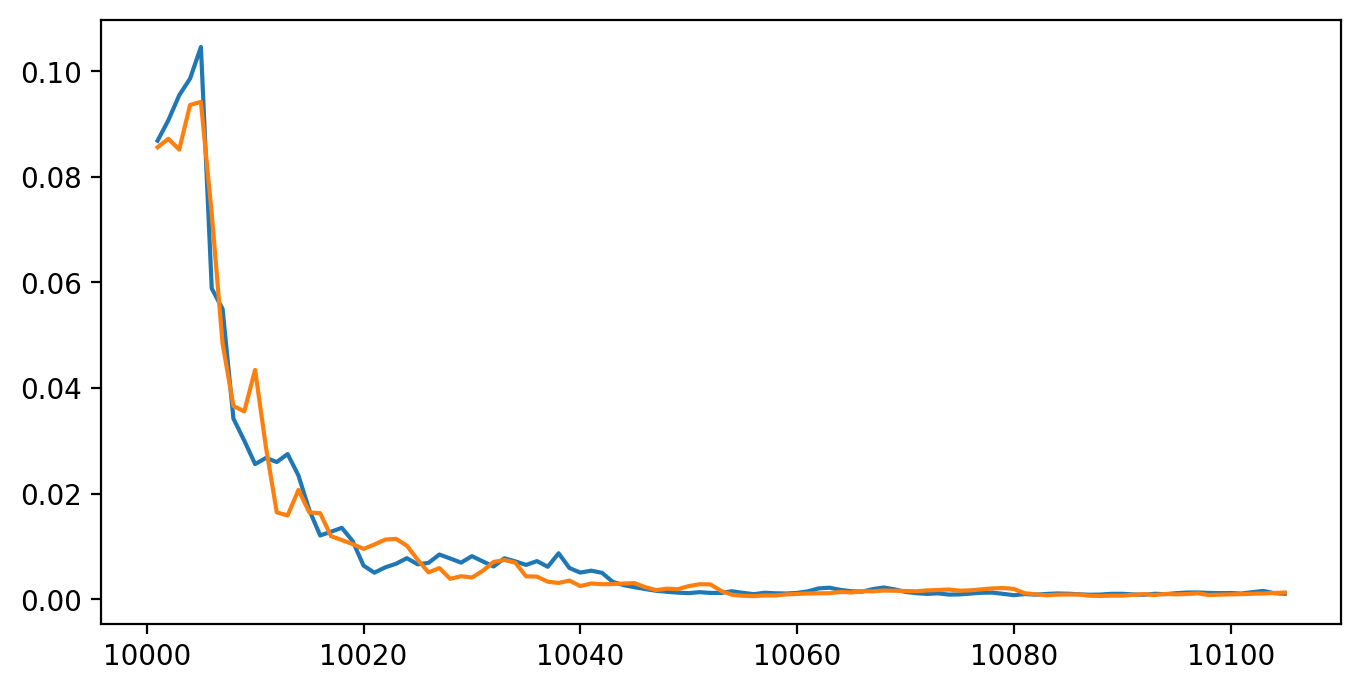

In [127]:
plt.plot(sim_stats[0].stats.generation, sim_stats[0].stats.zvar_1)
plt.plot(sim_stats[0].stats.generation, sim_stats[0].stats.zvar_2)
#plt.axvline(10010, c='gray')

In [120]:
def freqs_for_covmat(frqs, times, pops=None, fixed_to_nan=False):
    use_masked = fixed_to_nan
    samples = [(pop, time) for pop, time in zip(pops, np.concatenate((times, times)))]
    freqmat = frqs.copy()
    if fixed_to_nan:
        freqmat[np.logical_or(freqmat == 0., freqmat == 1.)] = np.nan
    d = TemporalFreqs(freqmat, samples)
    return d, d.calc_cov(use_masked=use_masked)

def covs_from_file(file, *args, **kwargs):
    return freqs_for_cov(sf.parse_slim_ragged_freqs(file), *args, **kwargs)

def covs_from_twopop(file_1, file_2, end=None, *args, **kwargs):
    freqs_1 = sf.parse_slim_ragged_freqs(file_1)
    freqs_2 = sf.parse_slim_ragged_freqs(file_2)
    assert(freqs_1.freqs.shape == freqs_2.freqs.shape)
    times = np.arange(freqs_1.freqs.shape[0])
    assert(freqs_1.positions == freqs_2.positions)
    fqs_1 = freqs_1.freqs
    fqs_2 = freqs_2.freqs
    if end is not None:
        fqs_1 = fqs_1[np.arange(end), :]
        fqs_2 = fqs_2[np.arange(end), :] 
        times = times[np.arange(end)]
    freqs = np.concatenate((fqs_1, fqs_2), axis=0)
    pops = [0] * fqs_1.shape[0] + [1] * fqs_2.shape[0]
    return freqs_for_covmat(freqs, times, pops, *args, **kwargs)


In [121]:
neut_files_1 = glob.glob(datadir + file + "_subpop1_neutfreqs.tsv")
neut_files_2 = glob.glob(datadir + file + "_subpop2_neutfreqs.tsv")

In [122]:
d, covs = covs_from_twopop(neut_files_1[0], neut_files_2[0], end=65)

In [81]:
g = d.calc_G()

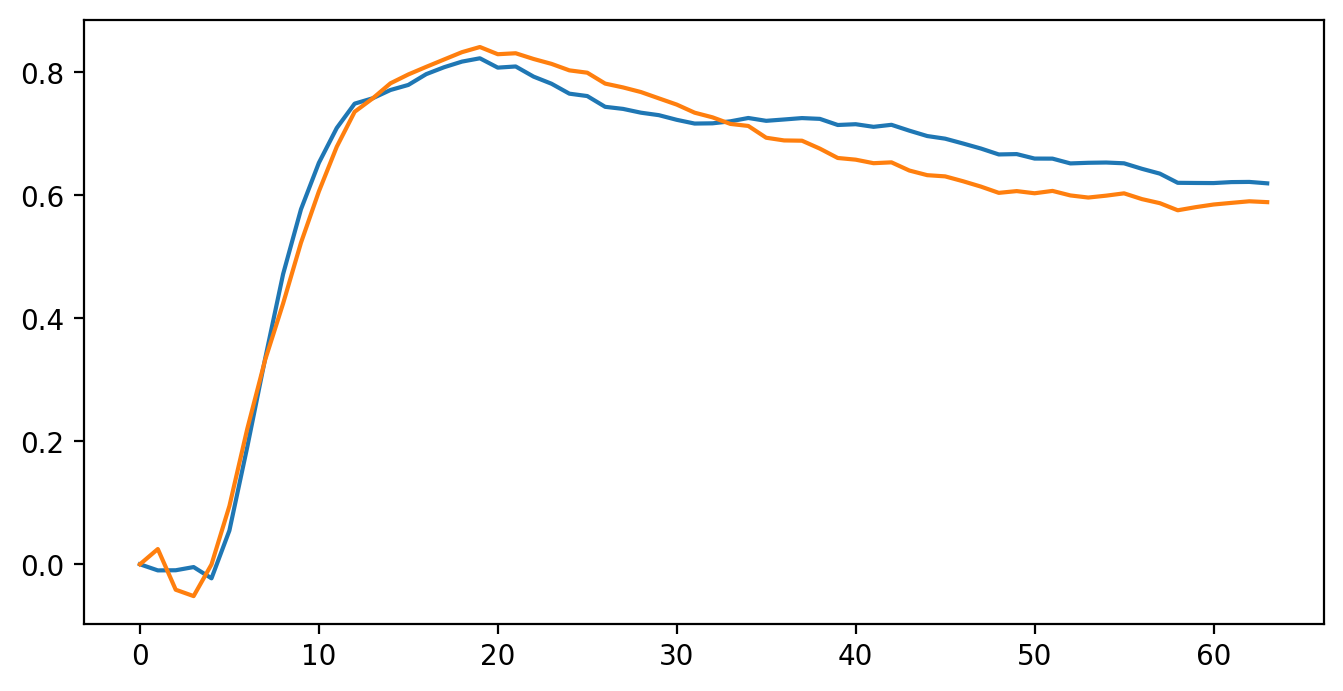

In [82]:
plt.plot(g)

In [83]:
a = stack_temporal_covariances(covs, d.R, d.T)

In [84]:
a.shape

(64, 64, 2)

In [85]:
am = a.mean(axis=2)
am.shape

(64, 64)

In [50]:
b = stack_replicate_covariances(covs, d.R, d.T)

In [125]:
cc = d.convergence_corr(use_masked=False)
cc.shape

(1, 64, 64)

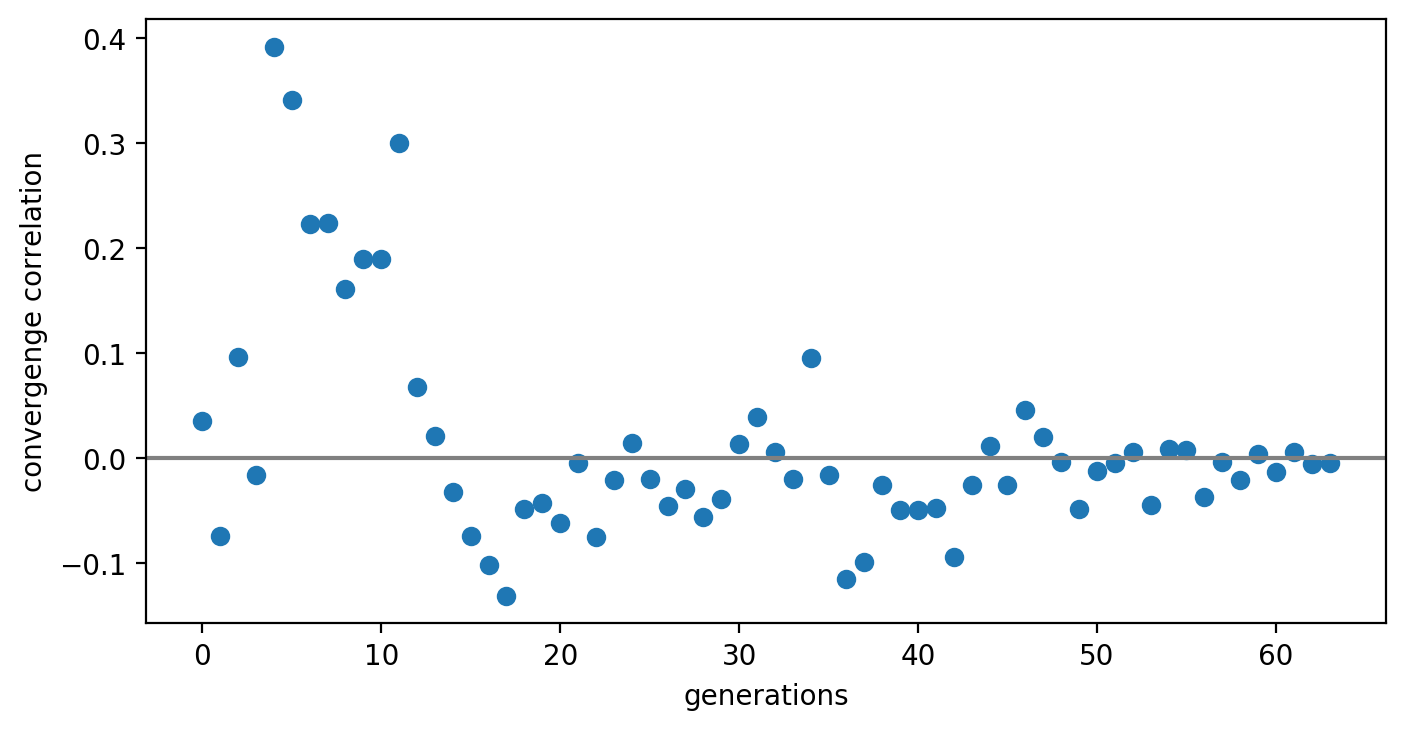

In [126]:
plt.plot(cc[0, 5, :], 'o')
plt.ylabel('convergenge correlation')
plt.xlabel('generations')
plt.axhline(0, c='gray')

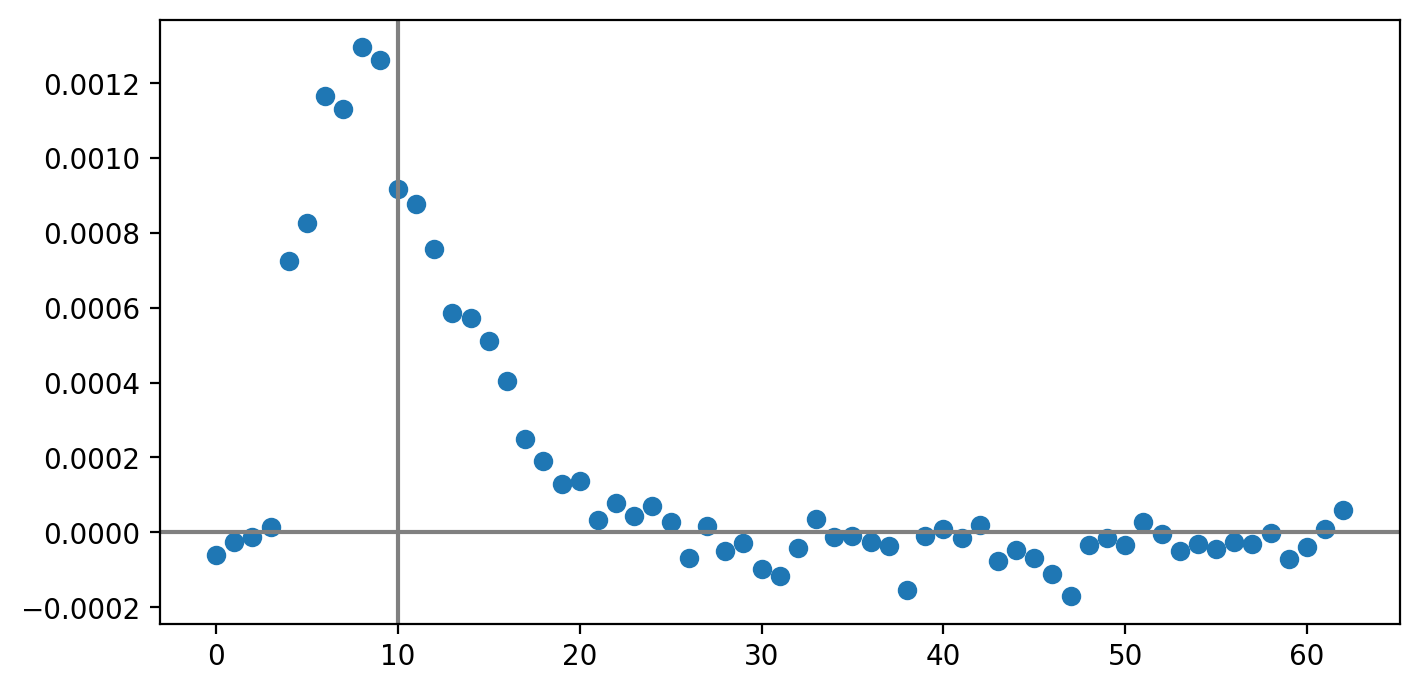

In [111]:
n = am.shape[0]
ref = 6
idx = (np.arange(n) != ref) & (np.arange(n) < 100)
plt.plot(am[ref, idx], 'o')
plt.axhline(0, c='gray')
plt.axvline(10, c='gray')

## Comparision of Total Variance

### N = 1000

In [139]:
nr = 50
neut_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]
bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.1s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]
weak_bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.01s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]
semi_bgs_files_1e3N = sorted(glob.glob(datadir + "bgs_1000N_1e-08rbp_0.05s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:nr]

In [140]:
def freqs_for_cov(frqs, burnin = 10000, gens=150, with_G=True, fixed_to_nan=False):
    use_masked = fixed_to_nan
    idx = np.array([i for i, time in enumerate(frqs.samples) if 
                    burnin <= time <= burnin + gens])
    samples = [(0, time) for time in idx]
    freqmat = frqs.freqs[idx, :]
    if fixed_to_nan:
        freqmat[np.logical_or(freqmat == 0., freqmat == 1.)] = np.nan
    d = TemporalFreqs(freqmat, samples)
    if with_G:
        return d.calc_cov(use_masked=use_masked), d.calc_G(use_masked=use_masked)
    return d.calc_cov(use_masked=use_masked)

def covs_from_file(file, *args, **kwargs):
    return freqs_for_cov(sf.parse_slim_ragged_freqs(file), *args, **kwargs)


In [141]:
pool = Pool(processes=10)

In [142]:
#bgs_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in bgs_files]
bgs_covs_1e3N = pool.map(covs_from_file, bgs_files_1e3N)

In [143]:
#weak_bgs_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in weak_bgs_files]
weak_bgs_covs_1e3N = pool.map(covs_from_file, weak_bgs_files_1e3N)

In [144]:
semi_bgs_covs_1e3N = pool.map(covs_from_file, semi_bgs_files_1e3N)

In [145]:
#neut_covs = [freqs_for_cov(sf.parse_slim_ragged_freqs(f)) for f in neut_files]
neut_covs_1e3N = pool.map(covs_from_file, neut_files_1e3N)

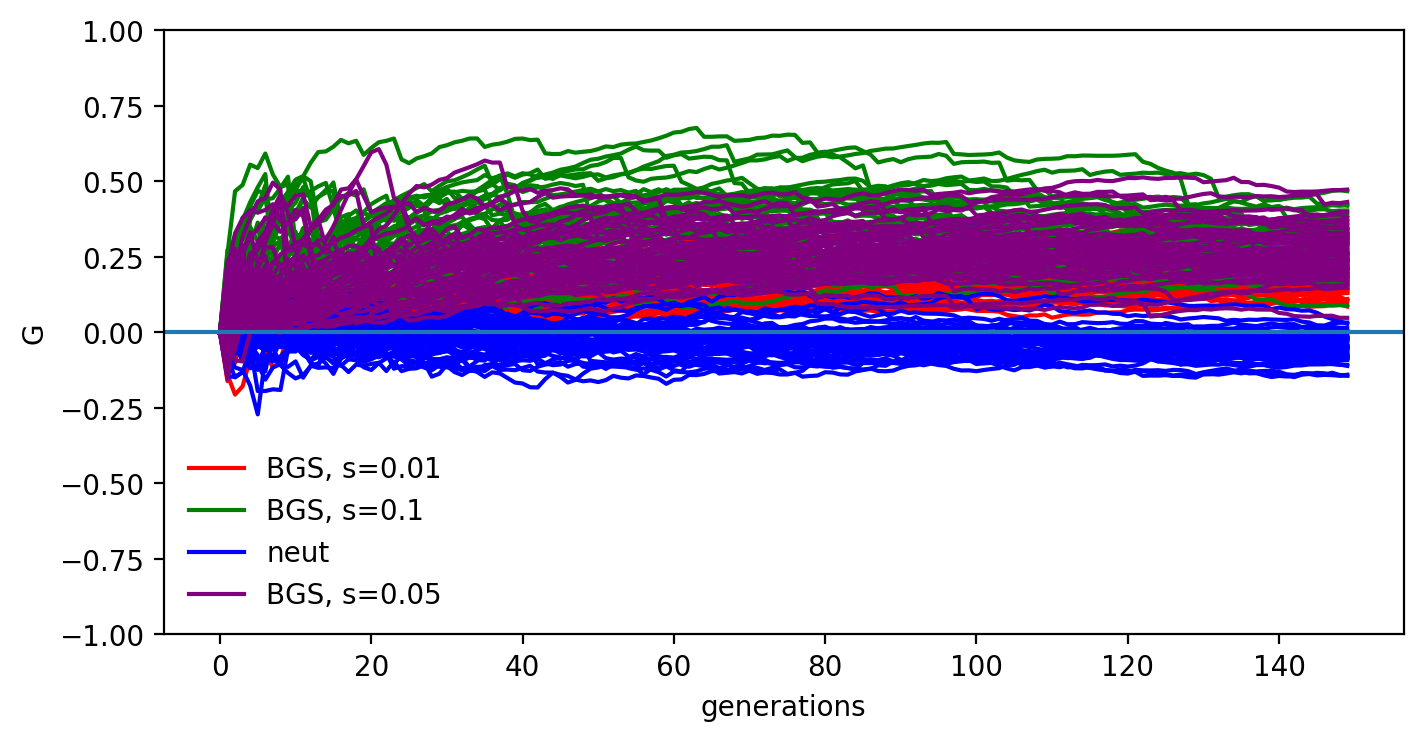

In [146]:
G_bgs_1e3N = [g for _, g in bgs_covs_1e3N]
G_weak_bgs_1e3N = [g for _, g in weak_bgs_covs_1e3N]
G_neut_1e3N = [g for _, g in neut_covs_1e3N]
G_semi_1e3N = [g for _, g in semi_bgs_covs_1e3N]


for i, g in enumerate(G_weak_bgs_1e3N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e3N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e3N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

    
for i, g in enumerate(G_semi_1e3N):
    lab = "BGS, s=0.05" if i == 0 else ""
    plt.plot(g, c='purple', label=lab)
    
plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

## Covariance Decays

In [147]:
covs_bgs_1e3N = np.array([c for c, _ in bgs_covs_1e3N]).mean(axis=0)
covs_weak_bgs_1e3N = np.array([c for c, _ in weak_bgs_covs_1e3N]).mean(axis=0)
covs_neut_1e3N = np.array([c for c, _ in neut_covs_1e3N]).mean(axis=0)
covs_semi_bgs_1e3N = np.array([c for c, _ in semi_bgs_covs_1e3N]).mean(axis=0)

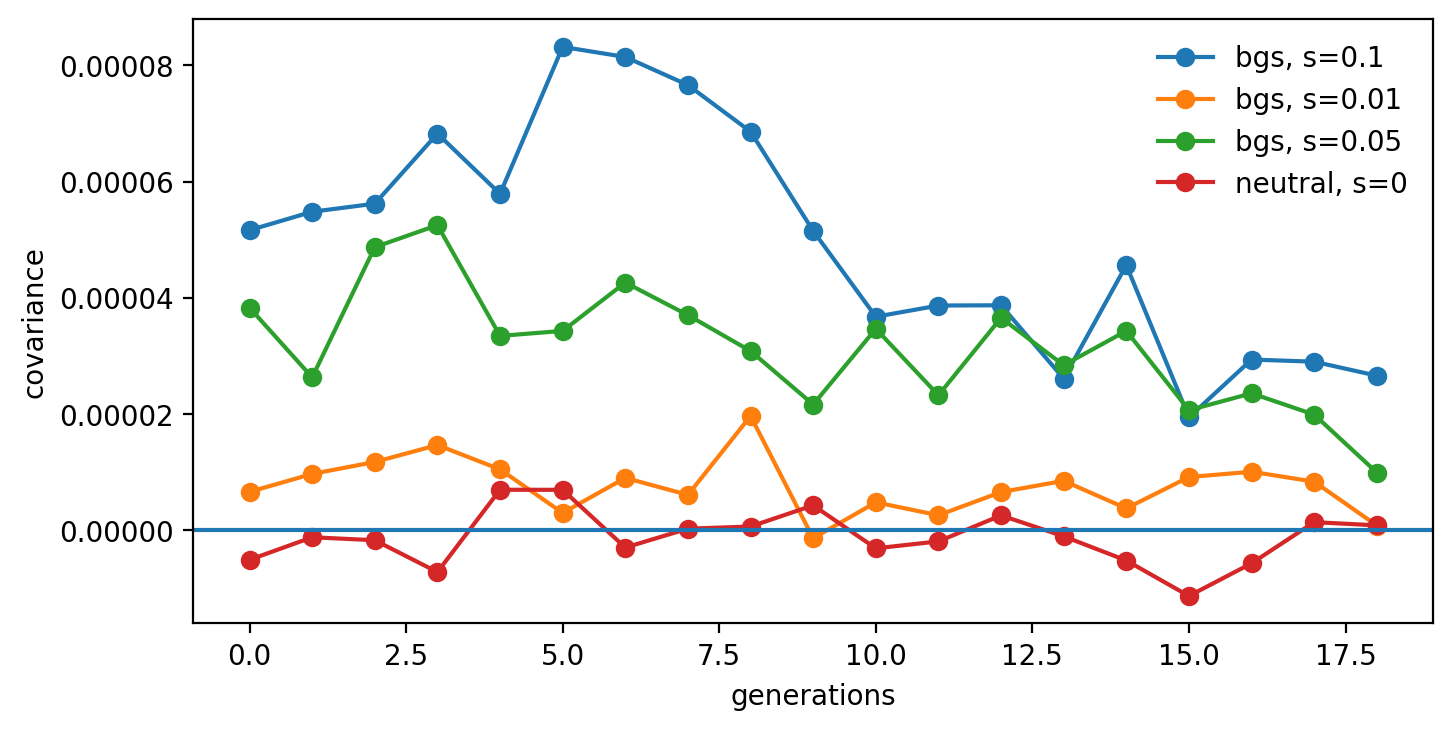

In [150]:
n = covs_bgs_1e3N[0].shape[0] # assumes these are all the same shape

ref = 5
idx = (np.arange(n) != ref) & (np.arange(n) < 20)


plt.plot(covs_bgs_1e3N[ref, idx], '-o',  label='bgs, s=0.1')

plt.plot(covs_weak_bgs_1e3N[ref, idx], '-o', label='bgs, s=0.01')
plt.plot(covs_semi_bgs_1e3N[ref, idx], '-o', label='bgs, s=0.05')

plt.plot(covs_neut_1e3N[ref, idx], '-o', label='neutral, s=0')


plt.ylabel('covariance')
plt.xlabel('generations')
plt.axhline(0)
plt.legend(frameon=False)

### With N = 100

With N = 100, fixations occur over a very short timescale. As such, this leads to negative covariance, an artifact of the method, when one does not mark fixations and losses as NaNs. Thus, below we use remove these. 

Note that one also needs to ignore fixed sites when calculating the level of variance for inferring Ne. In this case, fixed/loss sites have allele frequency change zero, and shrink the value towards zero.



In [17]:
neut_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
bgs_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0.1s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]
weak_bgs_files_1e2N = sorted(glob.glob(datadir + "bgs_100N_1e-08rbp_0.01s_1e-08nmu_1U_*_neutfreqs.tsv"))[0:20]

In [81]:
pool = Pool(processes=10)

In [19]:
# a temporary wrapper for these parameters
covs_from_file_wrapped = partial(covs_from_file, burnin=1000, fixed_to_nan=True)

bgs_covs_1e2N = pool.map(covs_from_file_wrapped, bgs_files_1e2N)

In [20]:
weak_bgs_covs_1e2N = pool.map(covs_from_file_wrapped, weak_bgs_files_1e2N)

In [21]:
neut_covs_1e2N = pool.map(covs_from_file_wrapped, neut_files_1e2N)

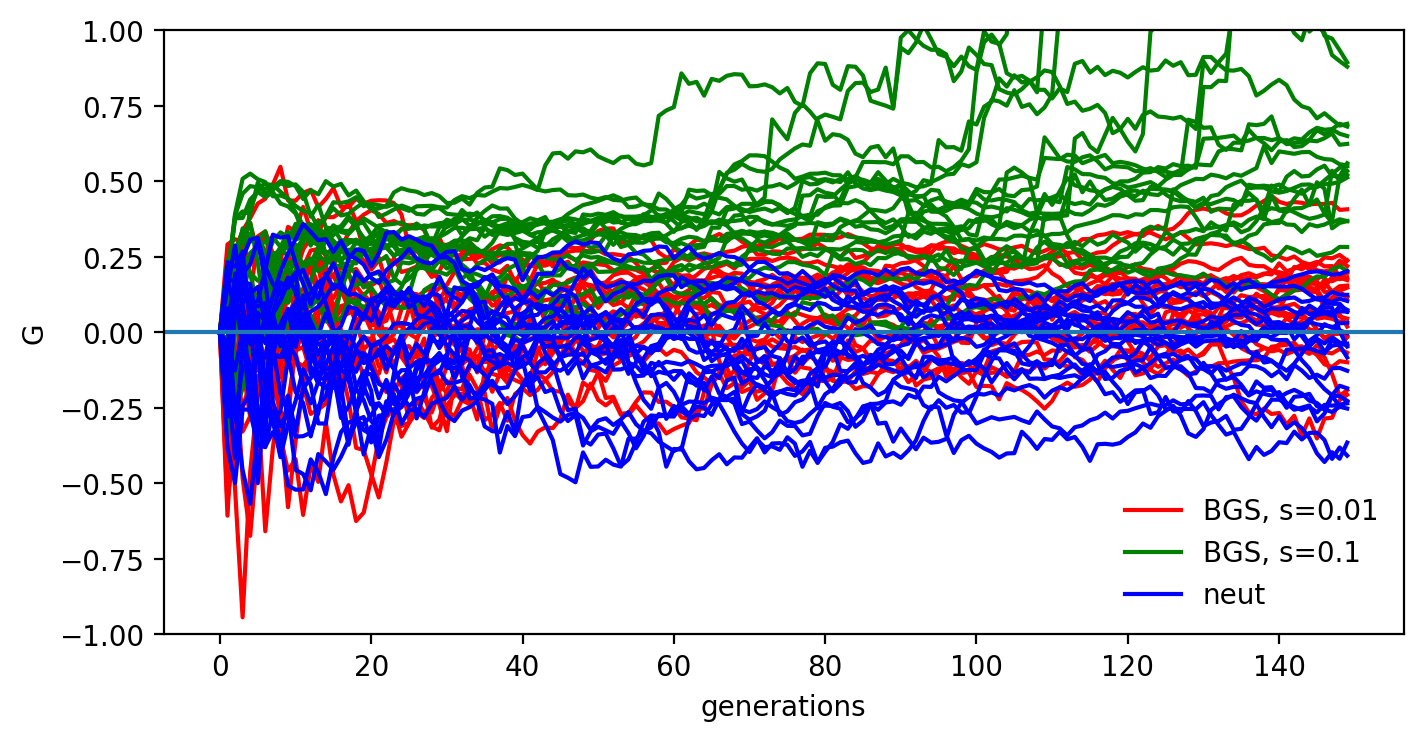

In [22]:
G_bgs_1e2N = [g for _, g in bgs_covs_1e2N]
G_weak_bgs_1e2N = [g for _, g in weak_bgs_covs_1e2N]
G_neut_1e2N = [g for _, g in neut_covs_1e2N]

for i, g in enumerate(G_weak_bgs_1e2N):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e2N):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e2N):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

### Without removing fixations

In [23]:
# a temporary wrapper for these parameters
covs_from_file_wrapped_withfix = partial(covs_from_file, burnin=1000, fixed_to_nan=False)

bgs_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, bgs_files_1e2N)

In [24]:
weak_bgs_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, weak_bgs_files_1e2N)

In [25]:
neut_covs_1e2N_fix = pool.map(covs_from_file_wrapped_withfix, neut_files_1e2N)

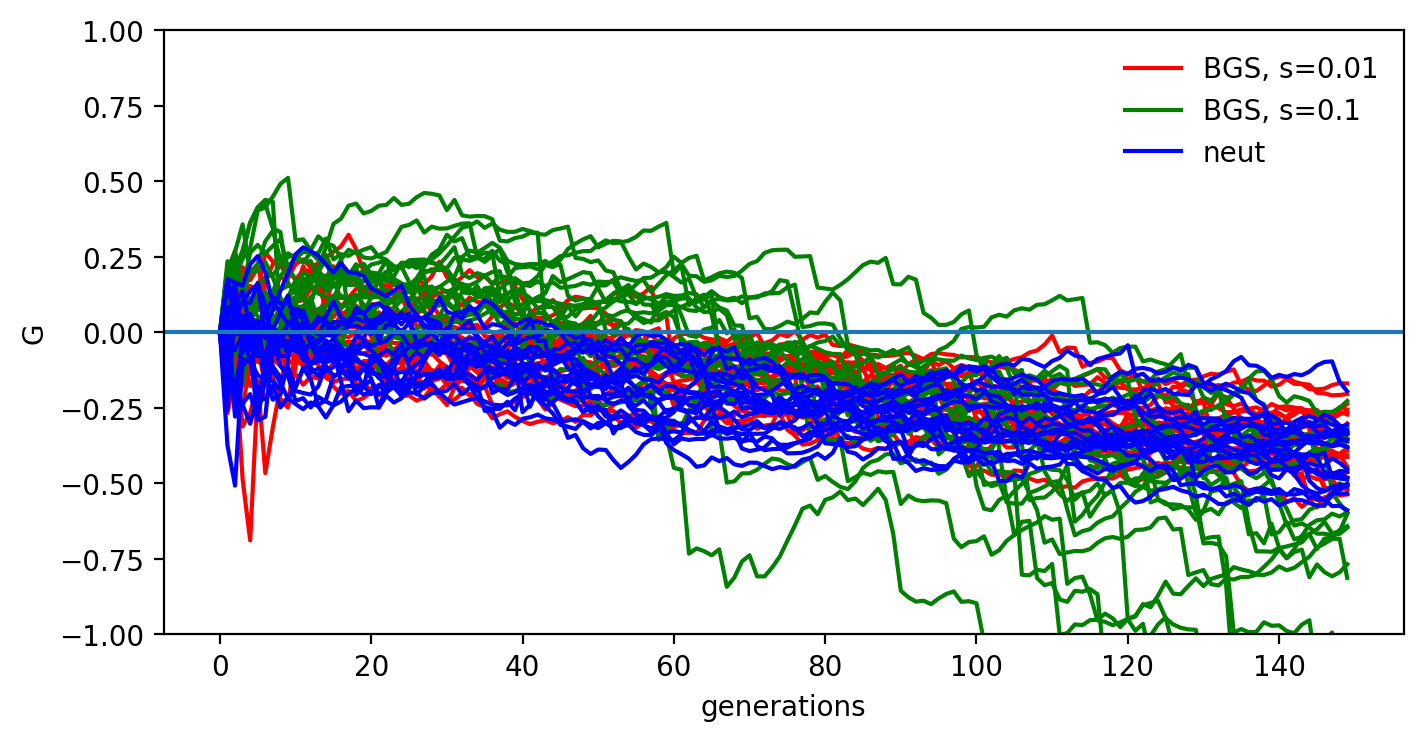

In [26]:
G_bgs_1e2N_fix = [g for _, g in bgs_covs_1e2N_fix]
G_weak_bgs_1e2N_fix = [g for _, g in weak_bgs_covs_1e2N_fix]
G_neut_1e2N_fix = [g for _, g in neut_covs_1e2N_fix]

for i, g in enumerate(G_weak_bgs_1e2N_fix):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs_1e2N_fix):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut_1e2N_fix):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)
plt.ylim(-1, 1)
plt.legend(frameon=False)

This shows how much processing fixations differently can affect things.

Maybe, replace fixations with NaNs, the sites contributiong to the long run covariances are those with really long fixation times. This implies they must have more "balanced" drifts – maybe this creates negative covariance? 

In [ ]:
G_bgs = [g for _, g in bgs_covs]
G_weak_bgs = [g for _, g in weak_bgs_covs]
G_neut = [g for _, g in neut_covs]

for i, g in enumerate(G_weak_bgs):
    lab = "BGS, s=0.01" if i == 0 else ""
    plt.plot(g, c='r', label=lab)

for i, g in enumerate(G_bgs):
    lab = "BGS, s=0.1" if i == 0 else ""
    plt.plot(g, c='g', label=lab)

for i, g in enumerate(G_neut):
    lab = "neut" if i == 0 else ""
    plt.plot(g, c='b', label=lab)

plt.ylabel('G')
plt.xlabel('generations')
plt.axhline(0)

plt.legend(frameon=False)

## Fixation Times

In [ ]:
neut_freqs_1e2N = [sf.parse_slim_ragged_freqs(f) for f in neut_files_1e2N]

In [70]:
def conditioned_covs(frqs, threshold, type='min', burnin = 1000, 
                     gens=150, with_G=True,):
    seg_gens = np.logical_and(frqs.freqs > 0, frqs.freqs < 1).sum(axis=0)
    
    idx = np.array([i for i, time in enumerate(frqs.samples) if 
                    burnin <= time <= burnin + gens])
    samples = [(0, time) for time in idx]
    # 
    cond = seg_gens > threshold if type == 'min' else seg_gens < threshold
    freqmat = frqs.freqs[idx, :][:, cond]
    d = TemporalFreqs(freqmat, samples)
    if with_G:
        return d.calc_cov(), d.calc_G()
    return d.calc_cov()

(array([13912.,   958.,   348.,   209.,   152.,   100.,    52.,    62.,
           49.,   325.]),
 array([  1.,  16.,  31.,  46.,  61.,  76.,  91., 106., 121., 136., 151.]),
 <a list of 10 Patch objects>)

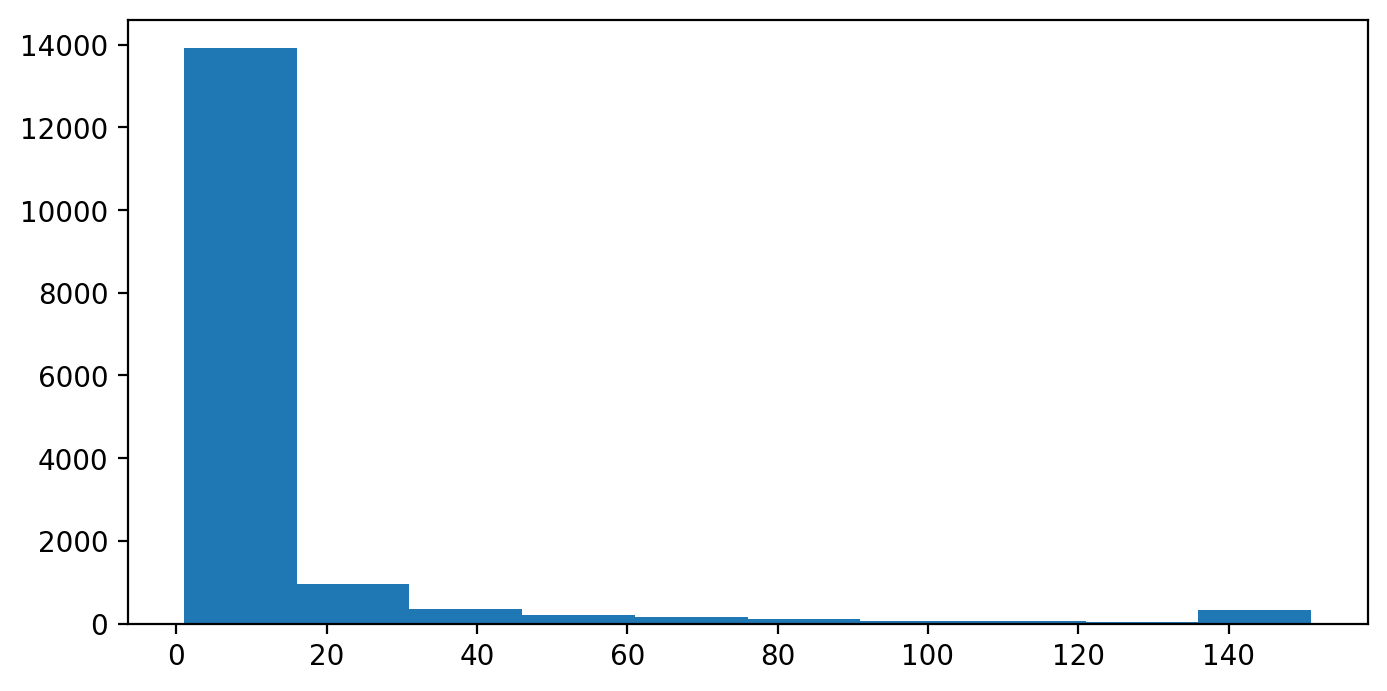

In [50]:
seg_gens = np.logical_and(neut_freqs_1e2N[0].freqs > 0, neut_freqs_1e2N[0].freqs < 1).sum(axis=0)

plt.hist(seg_gens[seg_gens > 0])

In [76]:
conditioned_slow = []
conditioned_fast = []
not_conditioned = []

for i in range(10):
    conditioned_slow.append(conditioned_covs(neut_freqs_1e2N[i], 140, 'min'))
    #conditioned_fast.append(conditioned_covs(neut_freqs_1e2N[i], 10, 'max'))
    not_conditioned.append(conditioned_covs(neut_freqs_1e2N[i], 0))

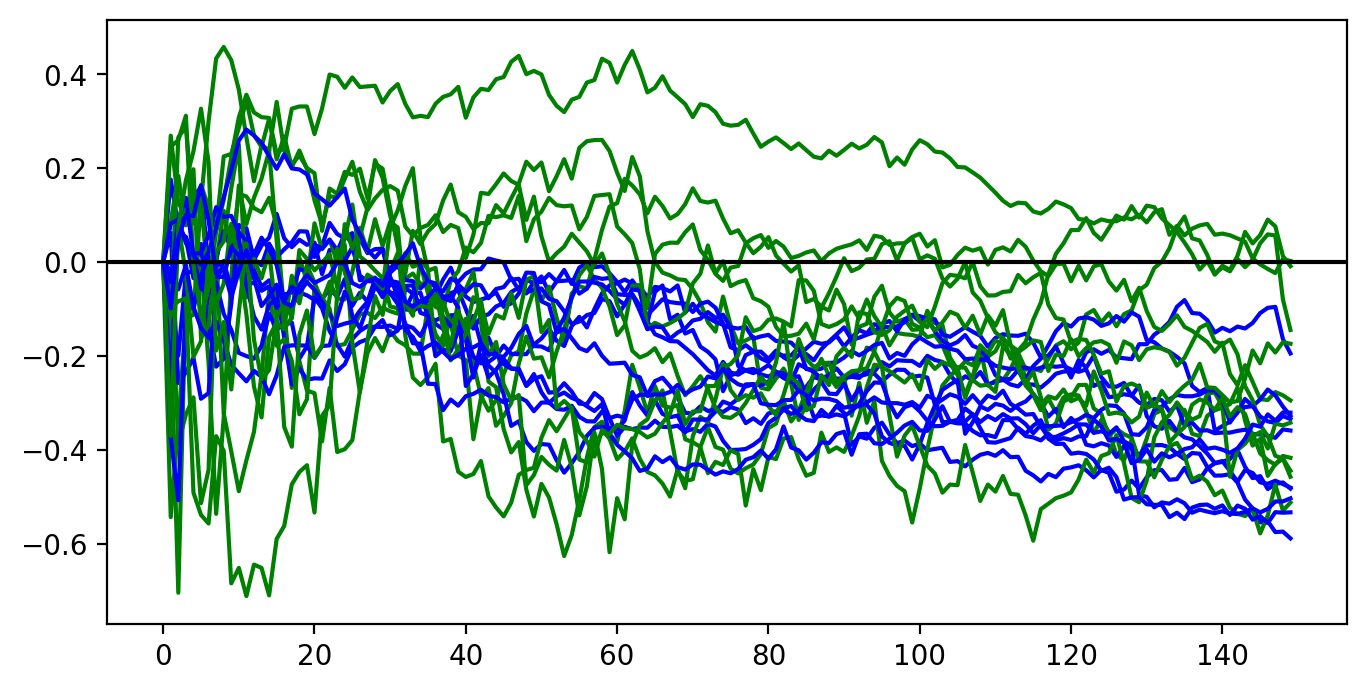

In [80]:
for i in range(10):
    #plt.plot(conditioned_fast[i][1], c='r')
    plt.plot(conditioned_slow[i][1], c='g')
    plt.plot(not_conditioned[i][1], c='b')
plt.axhline(0, c='k')

In [84]:
bgs_freqs_1e2N = [sf.parse_slim_ragged_freqs(f) for f in bgs_files_1e2N]

In [93]:
bgs_conditioned_slow = []
bgs_not_conditioned = []

for i in range(10):
    bgs_conditioned_slow.append(conditioned_covs(bgs_freqs_1e2N[i], 140, 'min'))
    #conditioned_fast.append(conditioned_covs(neut_freqs_1e2N[i], 10, 'max'))
    bgs_not_conditioned.append(conditioned_covs(bgs_freqs_1e2N[i], 0))

/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(30) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(10) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(9) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(23) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(17) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matrix has more samples (151) than loci(15) — did you supply the tranpose?
  warnings.warn(msg)
/home/vsb/projects/cvtk/cvtk/cvtk.py:39: UserWarning: freqs matri

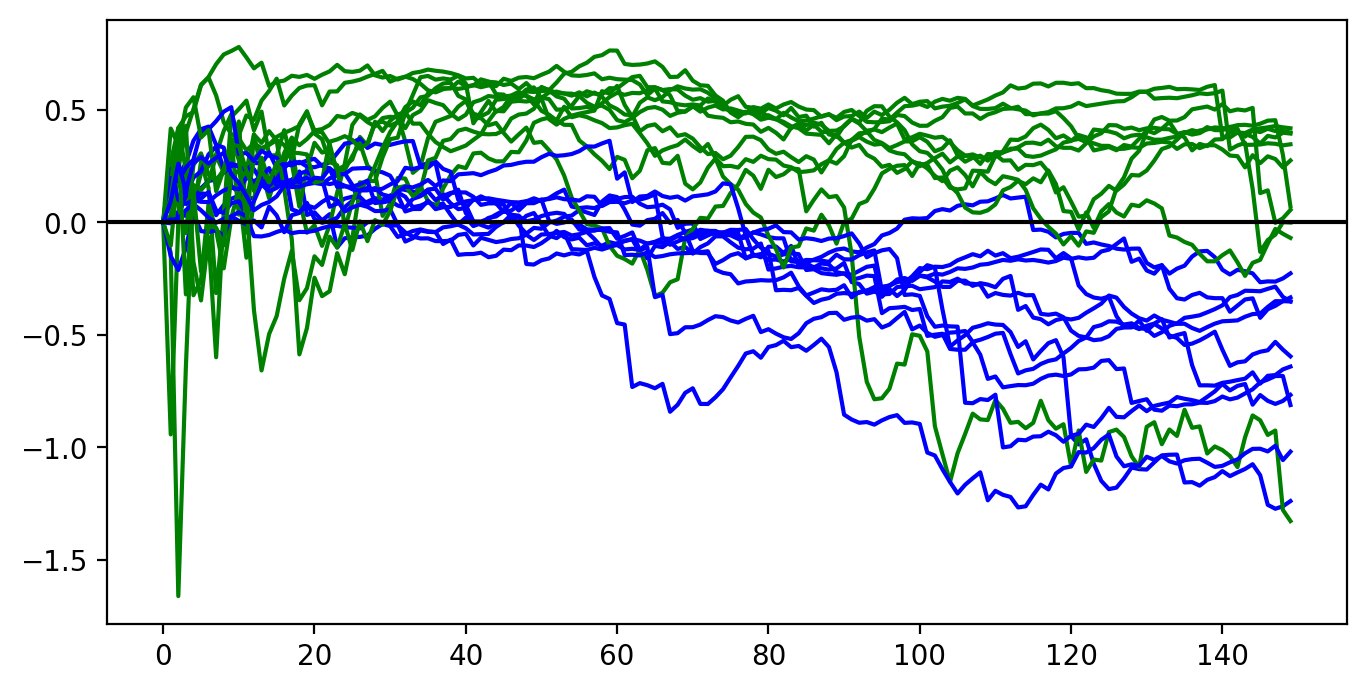

In [94]:
for i in range(10):
    #plt.plot(conditioned_fast[i][1], c='r')
    plt.plot(bgs_conditioned_slow[i][1], c='g')
    plt.plot(bgs_not_conditioned[i][1], c='b')
plt.axhline(0, c='k')

In [158]:
print(f"s = 0.1, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in bgs_covs]), 3)}\n" + 
  covs_from_file = 0.01, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in weak_bgs_covs]),3)}\n" + 
      f"s = 0.00, mean vars = {np.round(np.sum([np.diag(c).mean() for c, g in neut_covs]),3)}")

s = 0.1, mean vars = 0.038
s = 0.01, mean vars = 0.023
s = 0.00, mean vars = 0.009


In [159]:
print(
f"s = 0.1, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in bgs_covs]), 4)}\n" + 
f"s = 0.01, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in weak_bgs_covs]), 4)}\n" + 
f"s = 0.00, mean sum of covs = {np.round(np.mean([c[np.triu_indices(c.shape[1], k=1)].sum() for c, g in neut_covs]), 4)}")


s = 0.1, mean sum of covs = 0.0504
s = 0.01, mean sum of covs = 0.0122
s = 0.00, mean sum of covs = 0.0002


```
# sum of diagonals (variances), averaged across replicates
s = 0.1, mean vars = 0.038
s = 0.01, mean vars = 0.023
s = 0.00, mean vars = 0.009

# sum of upper triangle (covariances), averaged across replicates
s = 0.1, mean sum of covs = 0.0504
s = 0.01, mean sum of covs = 0.0122
s = 0.00, mean sum of covs = 0.0002

```

In [167]:
(0.5 * 60) / 0.009

3333.3333333333335